# Environment Setup

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/satellite-remote-sensing-image-data/PatternNet/patternnet_description.pdf
/kaggle/input/satellite-remote-sensing-image-data/PatternNet/images/oil_well/oilwell363.jpg
/kaggle/input/satellite-remote-sensing-image-data/PatternNet/images/oil_well/oilwell230.jpg
/kaggle/input/satellite-remote-sensing-image-data/PatternNet/images/oil_well/oilwell066.jpg
/kaggle/input/satellite-remote-sensing-image-data/PatternNet/images/oil_well/oilwell779.jpg
/kaggle/input/satellite-remote-sensing-image-data/PatternNet/images/oil_well/oilwell584.jpg
/kaggle/input/satellite-remote-sensing-image-data/PatternNet/images/oil_well/oilwell231.jpg
/kaggle/input/satellite-remote-sensing-image-data/PatternNet/images/oil_well/oilwell690.jpg
/kaggle/input/satellite-remote-sensing-image-data/PatternNet/images/oil_well/oilwell520.jpg
/kaggle/input/satellite-remote-sensing-image-data/PatternNet/images/oil_well/oilwell263.jpg
/kaggle/input/satellite-remote-sensing-image-data/PatternNet/images/oil_well/oilwell

# File path

In [2]:
data_dir="/kaggle/input/satellite-remote-sensing-image-data/PatternNet/images/"

# Import Necessaries libraries

In [3]:
!pip install imgaug --upgrade

Requirement already up-to-date: imgaug in /opt/conda/lib/python3.7/site-packages (0.4.0)


In [4]:
import tensorflow as tf
import cv2


from IPython.display import SVG

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [5]:
import os, sys


import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image, ImageOps

In [6]:
from sklearn.utils import class_weight, shuffle
from keras.losses import binary_crossentropy
from keras.applications.resnet50 import preprocess_input
import keras.backend as K

import warnings
warnings.filterwarnings("ignore")

from keras.utils import Sequence

In [7]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import (Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D,
                          BatchNormalization, Input, Conv2D, GlobalAveragePooling2D)

from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras.optimizers import Adam 
from keras import backend as K
import keras
from keras.models import Model
from keras.callbacks import Callback

from keras.regularizers import l2

# Parameters setting

In [8]:
SIZE = 256
WORKERS = 2
CHANNEL = 3
NUM_CLASSES = 38

# Sample Data Exploration for Understanding

In [9]:
TRAIN_PATH = '../input/satellite-remote-sensing-image-data/PatternNet/images'

TRAIN_FOLDERS = np.sort(os.listdir(TRAIN_PATH))

# Working on 35 class (all )
TRAIN_FOLDERS = np.array(pd.DataFrame(TRAIN_FOLDERS).sample(38)).reshape(-1)
train_labels = []

def generate_train_labels():
    for name in TRAIN_FOLDERS:
        images = os.listdir('../input/satellite-remote-sensing-image-data/PatternNet/images/'+name)
        for image in range(len(images)):
            train_labels.append(name)
            
            
generate_train_labels()


train_labels = pd.get_dummies(train_labels)

labels = train_labels


train_labels = np.float32(train_labels[list(TRAIN_FOLDERS)].values)

train_labels[:10]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [10]:
print(TRAIN_FOLDERS)

['basketball_court' 'storage_tank' 'parking_space' 'solar_panel'
 'intersection' 'runway_marking' 'beach' 'mobile_home_park' 'parking_lot'
 'tennis_court' 'crosswalk' 'coastal_mansion' 'swimming_pool'
 'nursing_home' 'airplane' 'river' 'ferry_terminal' 'oil_well' 'harbor'
 'overpass' 'oil_gas_field' 'shipping_yard' 'dense_residential'
 'golf_course' 'cemetery' 'football_field' 'transformer_station' 'bridge'
 'chaparral' 'wastewater_treatment_plant' 'christmas_tree_farm'
 'sparse_residential' 'runway' 'railway' 'closed_road' 'baseball_field'
 'forest' 'freeway']


In [11]:
fig = go.Figure(
                [go.Pie(labels=TRAIN_FOLDERS, 
                        values=labels.sum().values,
                        marker=dict(colors=['#026416','#C73104','#C05209','#6F2F05']))
                ])

fig.update_layout(width=900, height=400, title= {'text': "Satellite Image Patternnet Categories Distribution",
                                                'y':0.95,'x':0.43,
                                                'xanchor': 'center','yanchor': 'top'},
                 margin = dict(l=50, r=10, t=50, b=30))

# Data Augumentation & Data Manipulation , Train & Valid split...

In [12]:
data_dir = "/kaggle/input/satellite-remote-sensing-image-data/PatternNet/images/"
target_size = (SIZE,SIZE)
target_dims = (SIZE, SIZE, 3) # add channel for RGB
val_frac = 0.1
batch_size = 64

n_classes=NUM_CLASSES

data_augmentor = ImageDataGenerator(
                                    samplewise_center=True, 
                                    samplewise_std_normalization=True, 
                                    validation_split=val_frac)

train_generator = data_augmentor.flow_from_directory(data_dir, target_size=target_size, batch_size=batch_size, shuffle=True, subset="training")
validation_generator = data_augmentor.flow_from_directory(data_dir, target_size=target_size, batch_size=batch_size, subset="validation")

Found 27360 images belonging to 38 classes.
Found 3040 images belonging to 38 classes.


In [13]:
# keras imports for the dataset and building our neural network
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.utils import np_utils


In [14]:
# building a linear stack of layers with the sequential model
model = Sequential()

# convolutional layer
model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=target_dims))

# convolutional layer
model.add(Conv2D(64, kernel_size=(3,3), strides=(3,3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
# convolutional layer
model.add(Conv2D(128, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
# convolutional layer
model.add(Conv2D(512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# flatten output of conv
model.add(Flatten())

# hidden layer
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
# output layer

model.add(Dense(n_classes, activation='softmax'))



In [15]:
from keras.callbacks import ReduceLROnPlateau

In [16]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=15,
                                            verbose=1,
                                            factor=0.25,
                                            min_lr=0.000001)

model.compile(loss = 'categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(), metrics=['acc'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 86, 86, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 43, 43, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 11, 11, 128)       0

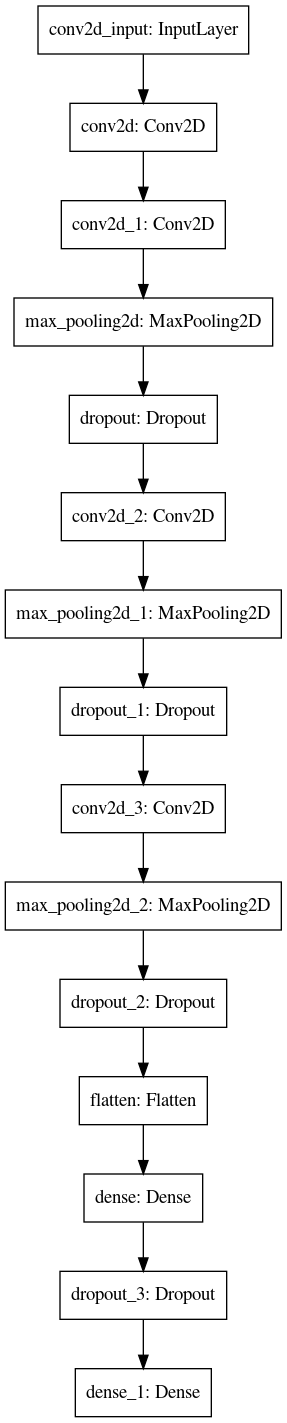

In [17]:
tf.keras.utils.plot_model(model)

# Prevent Overfitting & Save Best Model

In [18]:
# create callbacks list
from keras.callbacks import (ModelCheckpoint, LearningRateScheduler,
                             EarlyStopping, ReduceLROnPlateau,CSVLogger)

epochs = 20; batch_size = 64
checkpoint = ModelCheckpoint('../working/best_model.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, 
                                   verbose=1, mode='auto', epsilon=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=7)

csv_logger = CSVLogger(filename='../working/training_log.csv',
                       separator=',',
                       append=True)

In [19]:
callbacks_list = [checkpoint,csv_logger, reduceLROnPlat]

In [20]:
fit_history=model.fit_generator(
     train_generator,
    #train_mixup,
    #steps_per_epoch=np.ceil(float(len(train_indexes)) / float(batch_size)),
    validation_data=validation_generator,
    #validation_steps=np.ceil(float(len(valid_indexes)) / float(batch_size)),
    epochs=epochs,
    verbose=1,
    max_queue_size=16, workers=WORKERS, use_multiprocessing=True,
    callbacks=callbacks_list)

Epoch 1/20
428/428 [==============================] - ETA: 0s - loss: 1.9051 - acc: 0.4605
Epoch 00001: val_loss improved from inf to 1.02152, saving model to ../working/best_model.h5
428/428 [==============================] - 204s 478ms/step - loss: 1.9051 - acc: 0.4605 - val_loss: 1.0215 - val_acc: 0.6806
Epoch 2/20
428/428 [==============================] - ETA: 0s - loss: 0.6425 - acc: 0.8038
Epoch 00002: val_loss improved from 1.02152 to 0.62161, saving model to ../working/best_model.h5
428/428 [==============================] - 186s 434ms/step - loss: 0.6425 - acc: 0.8038 - val_loss: 0.6216 - val_acc: 0.7977
Epoch 3/20
428/428 [==============================] - ETA: 0s - loss: 0.3974 - acc: 0.8755
Epoch 00003: val_loss improved from 0.62161 to 0.48760, saving model to ../working/best_model.h5
428/428 [==============================] - 200s 467ms/step - loss: 0.3974 - acc: 0.8755 - val_loss: 0.4876 - val_acc: 0.8349
Epoch 4/20
428/428 [==============================] - ETA: 0s - l

In [21]:
#model.load_weights("../working/best_model.h5")

In [22]:
print(fit_history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


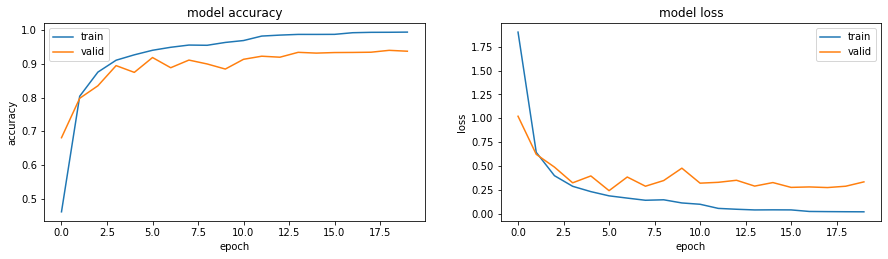

In [23]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['acc'])  
plt.plot(fit_history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()
